# Predicting Bike Rentals in Washington D.C.

Many American cities have communal bike sharing stations where one can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.
### The Dataset
Hadi Fanaee-T at the University of Porto compiled this data into a [CSV file](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/) containing 17380 rows, with each row representing the number of bike rentals for a single hour of a single day.

Relevant column descriptions:

- instant - A unique sequential ID number for each row
- dteday - The date of the rentals
- season - The season in which the rentals occurred
- yr - The year the rentals occurred
- mnth - The month the rentals occurred
- hr - The hour the rentals occurred
- holiday - Whether or not the day was a holiday
- weekday - The day of the week (as a number, 0 to 7)
- workingday - Whether or not the day was a working day
- weathersit - The weather (as a categorical variable)
- temp - The temperature, on a 0-1 scale
- atemp - The adjusted temperature
- hum - The humidity, on a 0-1 scale
- windspeed - The wind speed, on a 0-1 scale
- casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- registered - The number of registered riders (people who had already signed up)
- cnt - The total number of bike rentals (casual + registered)


### The Goal
**My goal is to predict the total number of bikes people rented in a given hour.** I'll predict the 'cnt' column using all of the other columns except for 'casual' and 'registered'. To accomplish this, I'll create a few different machine learning models and evaluate their performance.

## Preparing the Essentials

### Importing Necessary Python Libraries
I'll begin by importing various machine learning models from the scikit-learn library in order to evaluate the performance of each respective model. After doing so, I'll take a glance at the data.

In [1]:
# general data processing
import pandas as pd
import numpy as np

# data visualization 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

### Reading in the Dataset

Below are the first few rows of the dataset.

In [2]:
bike_rentals = pd.read_csv('hour.csv')
print(bike_rentals.head())

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  


### Exploratory Visualization
My goal is to use the provided columns in the dataset to predict the respective values in the 'cnt' column (supervised learning). I'll start by visualizing the target column using a histogram for bike_rentals and take a look at the distribution of total rentals.

array([[<AxesSubplot:title={'center':'cnt'}>]], dtype=object)

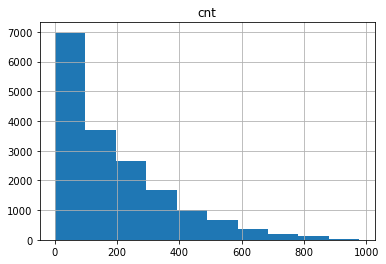

In [3]:
bike_rentals.hist(column = 'cnt')

I want to see how each of the columns correlate to the target column. To do so, I'll create a quick correlation table on the data.

In [4]:
bike_rentals.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

Below, I am quickly visualizing my correlation matrix to observe which columns seem to be correlated to the target column 'cnt'.

<AxesSubplot:>

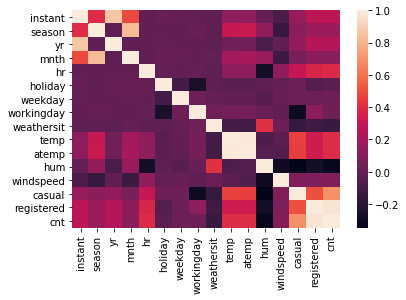

In [5]:
sns.heatmap(bike_rentals.corr())

# Feature Engineering

It can often be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information, or distilling existing information.

For example, the 'hr' column in the data contains the hours during which bikes are rented, from 1 to 24. A machine will treat each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This will bundle similar times together, enabling the model to make better decisions.

I'll define and apply a function to change the hour of the day into a general time of day below.

In [6]:
def assign_label(hour):
    if hour >=0 and hour < 6:
        return 4
    elif hour >=6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    elif hour >= 18 and hour <=24:
        return 3

bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
print(bike_rentals.head())

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  \
0           1  0.24  0.2879  0.81        0.0       3          13   16   
1           1  0.22  0.2727  0.80        0.0       8          32   40   
2           1  0.22  0.2727  0.80        0.0       5          27   32   
3           1  0.24  0.2879  0.75        0.0       3          10   13   
4           1  0.24  0.2879  0.75        0.0       0           1    1   

   time_label  
0           4  
1           4  
2           4  
3           4  
4           

## Splitting the Dataset into Training and Test Sets

Before applying machine learning algorithms, I need to split the data into training and testing sets. This will enable me to train an algorithm using the training set and evaluate its accuracy on the testing set. If I train an algorithm on the training data and evaluate its performance on the same data, I can get an unrealistically low error value (most likeley due to overfitting).

In [7]:
train = bike_rentals.sample(frac = 0.8)

test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

### Generating a List of Features for Training

I'll need to ignore the 'casual' and 'registered' columns because 'cnt' is derived from them. If I'm trying to predict the number of people who rent bikes in a given hour, it doesn't make sense to already know the numbers that are added together to get my target column. I'll create a list of predictor columns to use in training and predictions by removing my target column, the two columns I mentioned above, and the date column.

In [8]:
predictors = list(train.columns)
predictors.remove('cnt')
predictors.remove('casual')
predictors.remove('registered')
predictors.remove('dteday')

print(predictors)

['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'time_label']


### Defining a Function to Print Error Metrics on Models

In [9]:
def print_model_eval(string, mse, rmse):
    print('Model: {}'.format(string))
    print('Mean Squared Error: {}'.format(round(mse, 2)))
    print('Root Mean Squared Error: {}'.format(round(rmse, 2)))

## Building the Algorithms

### Linear Regression Model

Linear regression works best when predictors are linearly correlated to the target and also independent. Linear regression will probably work fairly well on this data given that many of the columns are highly correlated with 'cnt'.

The good thing about linear regression is that it's fairly resistant to overfitting because it's straightforward. It also can be prone to underfitting the data, however, and not building a powerful enough model. This means that linear regression usually isn't the most accurate option.

In [10]:
# fitting the model
model_1 = LinearRegression()
model_1.fit(X = train[predictors], y = train['cnt'])

# making predictions on the test data
m1_test_predictions = model_1.predict(test[predictors])

# evaluating the model
m1_mse = mean_squared_error(m1_test_predictions, test['cnt'])
m1_rmse = np.sqrt(m1_mse)

print_model_eval('Linear Regression', m1_mse, m1_rmse)

Model: Linear Regression
Mean Squared Error: 17724.26
Root Mean Squared Error: 133.13


The error for this model is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with MSE, which leads to a higher total error.

### Decision Trees

Decision trees tend to predict outcomes much more reliably than linear regression models. Because a decision tree is a fairly complex model, it also tends to overfit, particularly when parameters are not tweaked, like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability, and small changes in the input data can result in a very different output model.

In [11]:
# fitting the model
model_2 = DecisionTreeRegressor()
model_2.fit(X = train[predictors], y = train['cnt'])

# making predictions on the test data
m2_test_predictions = model_2.predict(test[predictors])

# evaluating the model
m2_mse = mean_squared_error(m2_test_predictions, test['cnt'])
m2_rmse = np.sqrt(m2_mse)

print_model_eval('Decision Trees', m2_mse, m2_rmse)

Model: Decision Trees
Mean Squared Error: 3182.26
Root Mean Squared Error: 56.41


By taking the nonlinear predictors into account, the decision tree regressor appears to have much higher accuracy than linear regression.

### Random Forest

The random forest algorithm improves on the decision tree algorithm. Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests can still be prone to overfitting though, so it's important to tune parameters like maximum depth and minimum samples per leaf.

In [12]:
# fitting the model
model_3 = RandomForestRegressor()
model_3.fit(X = train[predictors], y = train['cnt'])

# making predictins on the test data
m3_test_predictions = model_3.predict(test[predictors])

# evaluating the model
m3_mse = mean_squared_error(m3_test_predictions, test['cnt'])
m3_rmse = np.sqrt(m3_mse)

print_model_eval('Random Forest', m3_mse, m3_rmse)

Model: Random Forest
Mean Squared Error: 1508.51
Root Mean Squared Error: 38.84


By removing some of the sources of overfitting, the random forest accuracy is improved over the decision tree accuracy.

## Discussion

The random forest model achieved better results than just one decision tree and a simple linear regression model. Logistic regression would not be used given the target column is a continuous variable, not a discrete one. 